<a href="https://colab.research.google.com/github/masa512/SA/blob/main/SA_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd ../content
!git clone https://masa512:@github.com/masa512/SA.git

!git config --global user.email "ms4@illinois.edu"
!git config --global user.name "masa512"

%cd SA

/content
Cloning into 'SA'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 1), reused 2 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 1.10 MiB | 3.42 MiB/s, done.
/content/SA


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import circ_sample
%load_ext autoreload
%autoreload 2

# Test Circular Sample Function

In [ ]:
M,N = (100,50)
A = np.random.rand(M,N)
loc = (10,10)
rad = 10

Aprime = circ_sample.circ_sample(A,loc,rad)

[[0.49218843 0.74747373 0.3073459  ... 0.44604688 0.75137689 0.37804984]
 [0.61625908 0.94259146 0.70600121 ... 0.50073321 0.75543999 0.94465093]
 [0.12299932 0.01230823 0.85504357 ... 0.22166769 0.46378167 0.19539629]
 ...
 [0.15118295 0.10680557 0.04965488 ... 0.6066728  0.07317882 0.58431274]
 [0.04751681 0.14890329 0.34780765 ... 0.37642454 0.78437651 0.10227085]
 [0.93634231 0.41273826 0.06222603 ... 0.21930849 0.52702515 0.68599417]]


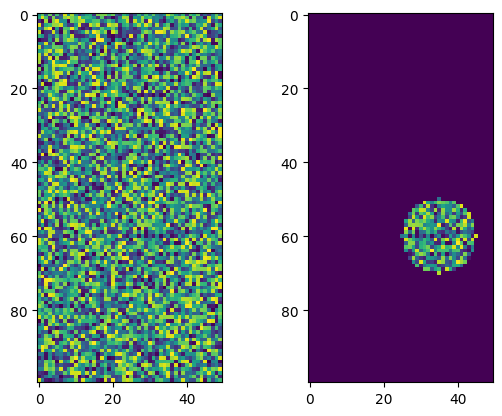

In [ ]:
plt.subplot(1, 2, 1)

plt.imshow(A)

plt.subplot(1, 2, 2)

plt.imshow(Aprime)

print(A)

# Plotting 2D Fourier Spectrum before sampling and after sample at center

In [ ]:
from skimage import data
from scipy.fft import ifftn,fftn,fftshift,ifftshift

I = data.camera() 

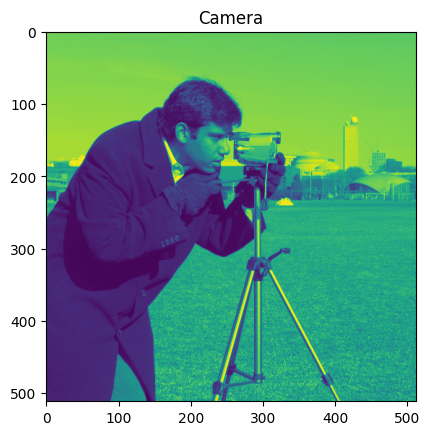

In [ ]:
plt.figure()
plt.title('Camera')
plt.imshow(I)

Text(0.5, 1.0, 'Phase Spectrum')

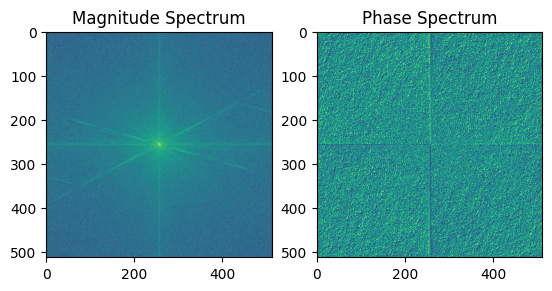

In [ ]:
F = fftshift(fftn(I))
plt.subplot(1, 2, 1)
plt.imshow(np.log(abs(F)))
plt.title('Magnitude Spectrum')

plt.subplot(1, 2, 2)
plt.imshow(np.angle(F))
plt.title('Phase Spectrum')

<ipython-input-8-456c18abcd64>:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(F_filt)))


Text(0.5, 1.0, 'Phase Spectrum')

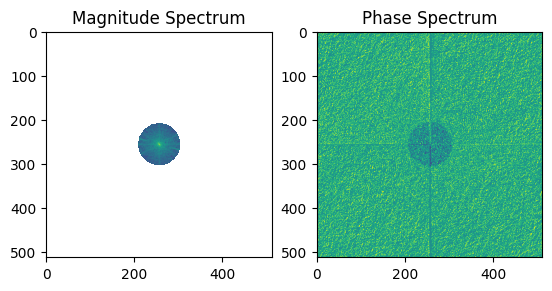

In [ ]:
# Apply FFT Sampling
c = 0
loc = (c,c)
rad = 50

F_filt = circ_sample.circ_sample(F,loc,rad)

plt.subplot(1, 2, 1)
plt.imshow(np.log(abs(F_filt)))
plt.title('Magnitude Spectrum')

plt.subplot(1, 2, 2)
plt.imshow(np.angle(F_filt))
plt.title('Phase Spectrum')


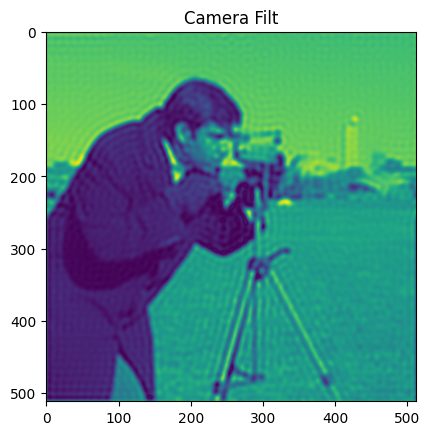

In [ ]:
# Reconstruction
I_filt = ifftn(ifftshift(F_filt))
plt.figure()
plt.title('Camera Filt')
plt.imshow(abs(I_filt))


# Stitching operation

<ipython-input-20-0b0af2cb9d0e>:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(F_filt)))


Text(0.5, 1.0, 'Phase Spectrum')

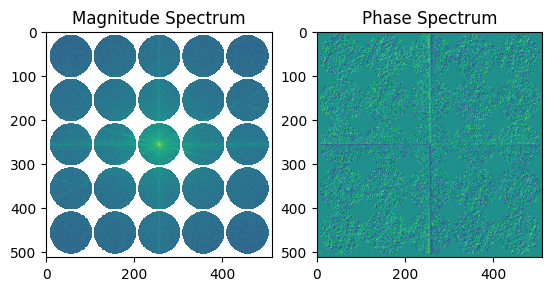

In [ ]:
# Apply FFT Sampling
L = 5
rad = 50

F_filt = circ_sample.stitch_samples(F,L,rad)

plt.subplot(1, 2, 1)
plt.imshow(np.log(abs(F_filt)))
plt.title('Magnitude Spectrum')

plt.subplot(1, 2, 2)
plt.imshow(np.angle(F_filt))
plt.title('Phase Spectrum')


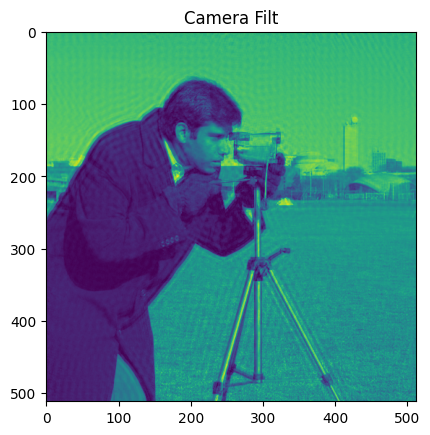

In [ ]:
# Reconstruction
I_filt = ifftn(ifftshift(F_filt))
plt.figure()
plt.title('Camera Filt')
plt.imshow(abs(I_filt))

In [ ]:
!git commit -a -m "Finished implementing Sampling"

[main 7dd80db] Finished implementing Sampling
 1 file changed, 36 insertions(+)


In [ ]:
!git push origin main


Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 700 bytes | 700.00 KiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/masa512/SA.git
   a4f38c8..7dd80db  main -> main


In [82]:
dataset = data_process.dog_train_dataset()

In [83]:
(I,F,M) = dataset[0]

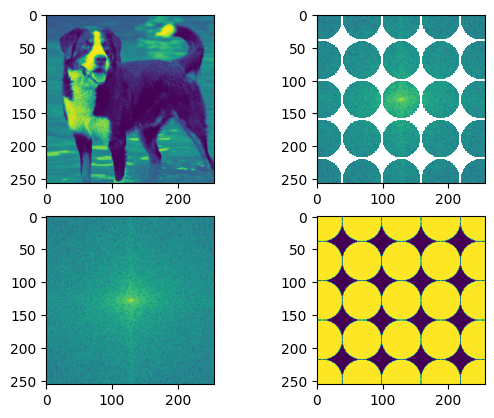

In [89]:
f,axes = plt.subplots(2,2)
axes = np.ravel(axes)
import torch
axes[0].imshow(I)
axes[1].imshow(torch.log(abs(F[0,:,:]*M)))
axes[2].imshow(torch.log(abs(F[0,:,:])))
axes[3].imshow(M)

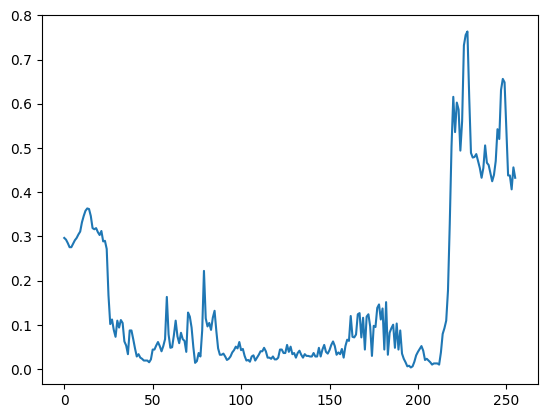